In [1]:
import scipy as sp
from scipy.io import arff
from cStringIO import StringIO
import pandas
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import sklearn.metrics.cluster as sk_cluster_m
import sklearn.metrics as skmetrics
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout
import math
from sklearn.metrics import adjusted_rand_score, calinski_harabaz_score
import matplotlib.patches as mpatches


In [2]:
## Function Utils
def rand_centroids(K, X):
    # rand_centroids(K=Int, X=Float_array):
    # Return a numpy array of size K with each element 
    # being a normally random distributed var with mu and sigma calculated 
    # from the mean and std of the data X
    mean, std = np.mean(X, axis=0), np.std(X, axis=0)
    centroids = [np.random.normal(mean, std) for n in range(K)]
    return np.array(centroids)

def euc_distance(X, Y):    
    # euc_distance(X=Float_array, Y=Float_array):
    # Returns an array of euclidean distances, 
    # for the square root of the sum of the square of the differences
    # of array X and array Y
    diff = X - Y[:, np.newaxis]
    squared_diff = diff**2
    sum_squared_diff = squared_diff.sum(axis=2)
    return np.sqrt(sum_squared_diff)

def compute_centroids(K, C, X):
    # compute_centroids(K=Int, C=Float_array, X=Float_array)
    # Compute the centroids for cluster size K, centroid(s) C and data X
    # where a new centroid is calculated as the mean of the data points 
    # which share a common nearest centroid. Repeats until the sum of
    # the euc distances between centroids and points does not change, 
    # then returns the cluster of centroids
    D = euc_distance(X, C)
    CC = np.argmin(D, axis=0)
    C = np.array([new_centroid(k, X, CC) for k in range(K)])
    D2 = euc_distance(X, C)
    if (D.sum() == D2.sum()):
        return C, np.argmin(D2, axis=0)
    else:
        return compute_centroids(K, C, X)

def new_centroid(k, X, CC):
    # Returns a new centroid based on the mean of the points associated with it
    # if no points associated with it, generates a new one
    x = X[CC==k]
    if (len(x) > 0):
        return x.mean(axis=0)
    else: 
        return rand_centroids(1, X)[0]
    
def k_means(K, X, display_title=True):
    # k_means(K=Int, X=Float_array)
    # K-means for clust size K on dataset X using random initialised centroids
    # returns final cluster and predicted labels
    if display_title:
        print "Computing K-means with K=",K
    C = rand_centroids(K, X)
    return compute_centroids(K, C, X)

In [4]:
def Bk_means(X, K, k_means_iter=1, log_level=1):
    #Bk_means(X=ndarray, K=Int, k_means_iter=3)
    #X: data to cluster
    #K: number of clusters
    #k_means_iter: number of iteretations on the kmeans call. # of split cluster pairs.
    #log_level: 0 : no messages, 1 print messages 
    
    # Initialize cluster  assigment with all data
    clusters=np.zeros((X.shape[0],1))
    
    print "Computing Bisecting Kmeans with K=",K,"Iterations of internal kmeans splitting:",k_means_iter
    #Set initial number of cluster to 1 and iterate until number of clusters=K
    
    for k in range(1,K):
        if log_level:
            print "*********** NEW ITERATION ************* ", k
        similarity=[]
        potential_new_clusters={}

        if log_level:
            print "*********select cluster to split******"
        
        larger_cluster_index = select_split_cluster(clusters,"larger",log_level) #options: larger, heterogeny, 
        if log_level:
            print "Selected cluster: ", larger_cluster_index
        

        kmeans_data=X[np.where(clusters==larger_cluster_index),:]
        kmeans_data=kmeans_data[0]
        
        if log_level:
            print "*********Generate 2 clusters with Kmeans ******"
            print "*********Best of ", k_means_iter," results ******"
        
        for i in range(0,k_means_iter): 
        #if k_means_iter >1 then we select best k_means split with similarity 
            #potential_new_clusters[i] = KMeans(2, "random",1).fit_predict(kmeans_data)
            #potential_new_clusters[i] = KMeans(2).fit_predict(kmeans_data)
            #call to our kmeans function
            if log_level: 
                print k_means(2,kmeans_data)
            potential_new_clusters[i] = k_means(2,kmeans_data,display_title=False)[1]
            similarity.append(cost_function(kmeans_data,potential_new_clusters[i],log_level))
        
        #Select division based on similarity (min value max similarity)
        selected_division=potential_new_clusters[similarity.index(min(similarity))]
        
        if log_level:
            print "Selected case: ", similarity.index(min(similarity))
        
        new_clusters=selected_division
        new_clusters[np.where(selected_division==1)]=k
        new_clusters[np.where(selected_division==0)]=larger_cluster_index

        
        clusters[np.where(clusters[:]==larger_cluster_index)]=new_clusters

    if log_level:
        print "****** END OF BKmeans *********\n\n\n"    
    return clusters.flatten()

def squares_dist(x):
    #squares_dist(x=ndarray):
    #x: matrix N,M. N rows of data variables. 
    #.  M/2 columns are data features values, M/2 columns are cluster centroid coord. 
    #returns square distances
    
    return (sp.spatial.distance.pdist([x[:x.shape[0]/2],x[x.shape[0]/2:]], 'euclidean'))**2


def cost_function(data_n,clusters_n, log_level=1):
    #cost_function(data_n=ndarray,clusters_n:array)
    #data_n: clustered data
    #clusters_n: clusters association in the data (size: rows of data_n, 1)
    #returns the cost function value
    
    #Find the centroids of each cluster 
    mus=np.array([data_n[np.where(clusters_n==k)].mean(axis=0) for k in range(len(np.unique(clusters_n)))])
    
    #vector of mu feature values of the associated cluster for each data variable
    mus_complete=np.empty([clusters_n.shape[0],data_n.shape[1]])
    
    for k in range(len(np.unique(clusters_n))):
        
        mus_complete[np.where(clusters_n==k)]=mus[k]
    
    #calculate cost function
    cost_f=sum(np.apply_along_axis(squares_dist, axis=1,arr=np.concatenate((data_n,mus_complete),axis=1))) 
    cost_f=cost_f/data_n.shape[0]
    
    if log_level:
        print "Cost function kmeans split:",cost_f
    return cost_f

def select_split_cluster(clusters, criteria="larger", log_level=1):
    #select_split_cluster (clusters, criteria)
    #clusters: vector of data cluster association (1 column)
    #criteria= "larger". (more option tbi)
    #returns de number of the selected cluster.
    
    selected_key_c=0
    number_of_x=[]
    
    if criteria == "larger":
        for i in np.nditer(np.unique(clusters)):

            number_of_x.append([len(clusters[np.where(clusters==i)]),i])
        
        selected_key_c=number_of_x[number_of_x.index(max(number_of_x))][1]
        
        if log_level:
            print "Number of x in each cluster:", number_of_x

    return selected_key_c


In [7]:
def fcm(data, cluster_n, expo=2, max_iter=100, min_impro=1e-5, display=True,
        initU=None):
    # Data set clustering using fuzzy c-means clustering.
    # The Function finds N_CLUSTER number of clusters in the data set DATA.
    # DATA is size M-by-N, where M is the number of data points and N is the
    # number of coordinates for each data point. The coordinates for each
    # cluster center are returned in the rows of the matrix CENTER.
    # The membership function matrix U contains the grade of membership of
    # each DATA point in each cluster. The values 0 and 1 indicate no
    # membership and full membership respectively. Grades between 0 and 1
    # indicate that the data point has partial membership in a cluster.
    # At each iteration, an objective function is minimized to find the best
    # location for the clusters and its values are returned in OBJ_FCN.

    print "Computing FCM with K=",cluster_n,"and m=",expo
    
    data_n, in_n = data.shape
    obj_fcn = np.zeros((max_iter, 1))

    # Perform checks
    assert expo != 1, "Exponential parameter must be different from 1"

    U = initfcm(cluster_n, data_n, initU)
    for i in range(max_iter):
        U, center, obj_fcn[i] = stepfcm(data, U, cluster_n, expo)
        if display:
            print("Iteration count {}, obj. fcn = {}".format(i, obj_fcn[i][0]))
        # check termination condition
        if i > 0:
            if np.abs(obj_fcn[i] - obj_fcn[i-1]) < min_impro:
                break

    obj_fcn = obj_fcn[:(i + 1)]  # Actual number of iterations
    labels = np.argmax(U, axis=0)
    return center, U, obj_fcn, labels


def stepfcm(data, U, cluster_n, expo):
    # One step in fuzzy c-mean clustering.
    # performs one iteration of fuzzy c-mean clustering, where
    #
    # DATA: matrix of data to be clustered. (Each row is a data point.)
    # U: partition matrix. (U(i,j) is the MF value of data j in cluster i.)
    # CLUSTER_N: number of clusters.
    # EXPO: exponent (> 1) for the partition matrix.
    # U_NEW: new partition matrix.
    # CENTER: center of clusters. (Each row is a center.)

    # MF matrix after exponential modification
    mf = np.power(U, expo)

    # New center
    center = (np.dot(mf, data)
              / mf.sum(axis=1, keepdims=True) * np.ones((1, data.shape[1])))

    # fill the distance matrix
    dist = distfcm(center, data)

    # objective function
    obj_fcn = np.sum(np.power(dist, 2) * mf)

    # calculate new U, suppose expo != 1
    tmp = np.power(dist, -2/(expo-1))
    U_new = tmp/(np.ones((cluster_n, 1))*np.sum(tmp, axis=0, keepdims=True))

    return U_new, center, obj_fcn


def distfcm(center, data):
    # Distance measure in fuzzy c-mean clustering.
    # Calculates the Euclidean distance between each row in CENTER and each
    # row in DATA, and returns a distance matrix OUT of size M by N, where
    # M and N are row dimensions of CENTER and DATA, respectively, and
    # OUT(I, J) is the distance between CENTER(I,:) and DATA(J,:).
    out = np.zeros((center.shape[0], data.shape[0]))

    # fill the output matrix
    if center.shape[1] > 1:
        for k in range(center.shape[0]):
            out[k, :] = np.sqrt(np.sum(np.power(
                data - np.ones((data.shape[0], 1)) * center[k, :]
                , 2), axis=1))
    else:  # 1-D data
        for k in range(center.shape[0]):
            out[k, :] = np.abs(center[k]-data).transpose()

    return out


def initfcm(cluster_n, data_n, initU=None):
    # Generate initial fuzzy partition matrix for fuzzy c-means clustering.
    # If initU is provided, the function uses initU as the U matrix, otherwise
    # the function randomly generates a fuzzy partition matrix U that is
    # CLUSTER_N by DATA_N, where CLUSTER_N is number of clusters and
    # DATA_N is number of data points. The summation of each column of the
    # generated U is equal to unity, as required by fuzzy c-means clustering.

    if initU is None:
        U = np.random.rand(cluster_n, data_n)
    else:
        assert isinstance(initU, np.ndarray), "initU must be a numpy.ndarray"
        assert (cluster_n, data_n) == initU.shape, \
            "The dimensions of initU must be ({},{})".format(cluster_n, data_n)
        U = initU

    U = U/U.sum(axis=0, keepdims=True)
    return U

Computing K-means with K= 2
Computing Bisecting Kmeans with K= 2 Iterations of internal kmeans splitting: 1
Computing K-means with K= 3
Computing Bisecting Kmeans with K= 3 Iterations of internal kmeans splitting: 1
Computing K-means with K= 4
Computing Bisecting Kmeans with K= 4 Iterations of internal kmeans splitting: 1
Computing K-means with K= 5
Computing Bisecting Kmeans with K= 5 Iterations of internal kmeans splitting: 1
Computing K-means with K= 6
Computing Bisecting Kmeans with K= 6 Iterations of internal kmeans splitting: 1
Computing K-means with K= 7
Computing Bisecting Kmeans with K= 7 Iterations of internal kmeans splitting: 1
Computing K-means with K= 8
Computing Bisecting Kmeans with K= 8 Iterations of internal kmeans splitting: 1
Computing K-means with K= 9
Computing Bisecting Kmeans with K= 9 Iterations of internal kmeans splitting: 1
Computing K-means with K= 10
Computing Bisecting Kmeans with K= 10 Iterations of internal kmeans splitting: 1
Computing K-means with K= 

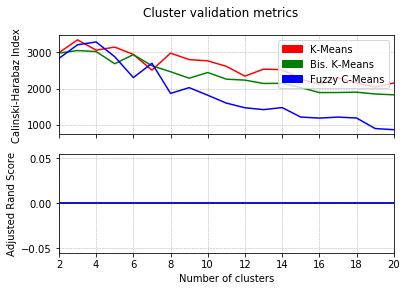

In [6]:
# Data Import
iris, iris_meta = arff.loadarff("datasets/iris.arff")
iris_data = np.array([iris['sepallength'], iris['sepalwidth'],
                      iris['petallength'], iris['petalwidth']]).transpose()
iris_class = iris['class'].reshape((150, 1))


penbased, penbased_meta = arff.loadarff("datasets/pen-based.arff")
penbased_data=np.zeros((len(penbased), len(penbased[0])-1))
penbased_class=np.zeros((len(penbased)))

i=0
for d in penbased:
    penbased_data[i,:]=[d[0],d[1],d[2],d[3],d[4],d[5],d[6],d[7],d[8],d[9],d[10],d[11],d[12],d[13],d[14],d[15]]
    penbased_class[i]=penbased[16][0]                
    i=i+1  


def compare_cluster_methods(data, labels_true, k_range=range(2, 21)):

    ch_scores_km = []; ch_scores_bkm = []; ch_scores_fcm = []
    ar_scores_km = []; ar_scores_bkm = []; ar_scores_fcm = []
    _, lab_codes = np.unique(labels_true, return_inverse=True)

    for k in k_range:
        _, labels_km = k_means(k, data)
        labels_bkm = Bk_means(data, k, log_level=0)
        _, _, _, labels_fcm = fcm(data, k,display=False)

        ch_scores_km.append(calinski_harabaz_score(data, labels_km))
        ch_scores_bkm.append(calinski_harabaz_score(data, labels_bkm))
        ch_scores_fcm.append(calinski_harabaz_score(data, labels_fcm))

        ar_scores_km.append(adjusted_rand_score(lab_codes, labels_km))
        ar_scores_bkm.append(adjusted_rand_score(lab_codes, labels_bkm))
        ar_scores_fcm.append(adjusted_rand_score(lab_codes, labels_fcm))

    f, (ax1, ax2) = plt.subplots(2, sharex=True)
    f.suptitle('Cluster validation metrics')
    ax1.plot(k_range, ch_scores_km, 'r',
             k_range, ch_scores_bkm, 'g',
             k_range, ch_scores_fcm, 'b')
    ax1.set_ylabel('Calinski-Harabaz Index')
    ax1.grid(linestyle='--', linewidth=0.5)
    ax1.legend(handles=[
        mpatches.Patch(color='r', label='K-Means'),
        mpatches.Patch(color='g', label='Bis. K-Means'),
        mpatches.Patch(color='b', label='Fuzzy C-Means')
    ], loc='upper right')

    ax2.plot(k_range, ar_scores_km, 'r',
             k_range, ar_scores_bkm, 'g',
             k_range, ar_scores_fcm, 'b')
    ax2.set_ylabel('Adjusted Rand Score')
    ax2.set_xlabel('Number of clusters')
    ax2.set_xlim(np.min(k_range), np.max(k_range))
    ax2.grid(linestyle='--', linewidth=0.5)

    plt.show()


#compare_cluster_methods(iris_data, iris_class)
compare_cluster_methods(penbased_data, penbased_class)
